# ALMACENAMIENTO Y PROCESAMIENTO MASIVO DE DATOS - TAREA 3

For this assignment, we will be working with the Yelp dataset for businessess reviews.

The objective of this notebook is:
1. Create a CSV file where the reviews are joined with the categories of the business reviewed.
    
2. Through Map-Reduce Jobs (MRJob), get the distributions of stars for each category, generating a CSV containing the final distribution.

3. With help of the MatPlotLib library, plot a histogram showing the distribution of stars for each business category.

# 1. Create a CSV file where the reviews are joined with the categories of the business reviewed.

* Example: business_1 has 3 categories: food, hamburgers and fast-food. Then, if review_1 is reviewing business_1 with a certain ammount of stars, the new CSV file will contain: 
        * review_1_id;food;stars;
        * review_1_id;hamburgers;stars;
        * review_1_id;fast-food;stars;
        
In the following block of code, we create a Python script called "generate_csv.py" which, when called, will generate the desired CSV file.

In [26]:
%%file generate_csv.py

import json
import re
import itertools
import sys

def get_json_element(line):
    ''' Had to create this function because my shrinked JSON were dumped as a list,
    not as various JSON Objects as in the original files, so this function
    handles both cases (multiple JSON objects and a LIST of JSON Objects) '''
    line = json.loads(line)
    if isinstance(line, list):
        for real_json_object in line:
            yield real_json_object
    else:
        yield line

BUSINESS_CATEGORIES = {}
business = sys.argv[1]
reviews = sys.argv[2]
out_name = sys.argv[3]
files = [business, reviews]
out_file = open(out_name, "w")
for f in files:
    opened_file = open(f,"r")
    for line in opened_file:
        for l in get_json_element(line):
            if 'categories' not in l:
                if l['business_id'] in BUSINESS_CATEGORIES:
                    categories = BUSINESS_CATEGORIES[l['business_id']]
                    for category in categories:
                        review_id = l['review_id']
                        stars = str(l['stars'])
                        out_file.write(review_id+';'+category+';'+stars+ '\n')
            else:
                BUSINESS_CATEGORIES[l['business_id']] = l['categories']
out_file.close()

Writing generate_csv.py


Then, we will call the generated python script, which needs to be given certain parameters:
1. Yelp business dataset (JSON)
2. Yelp review dataset (JSON)
3. Output file path.

For this example, we will use the medium datasets (30000 reviews).

The script should be called the following way:

In [27]:
! python generate_csv.py business_medium.json review_medium.json reviews_with_stars_by_category.csv

Now that the CSV file joining businessess categories and reviews is created, we can move on to the following step.

# 2. Through Map-Reduce Jobs (MRJob), get the distributions of stars for each category, generating a CSV containing the final distribution.

    * The CSV will contain the category and a list representing how many reviews gave 'i' stars to a business of said category, where 'i' is represented by the index in the list:
        * category_1;[0,1,0,3,4]
        * category_2:[1,2,4,0,0]
        * ...

We start by creating a Python script for all the Map-Reduce operations needed to obtain the star distribution for each category, this by using the MRJob library.

The script will be saved as a Python file called "mr_get_star_distribution.py" and it will return, line by line, the categories with their corresponding star distribution in CSV format.


In [28]:
%%file mr_get_star_distribution.py

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import json
import re
import itertools

from mr3px.csvprotocol import CsvProtocol

def get_json_element(line):
    ''' Had to create this function because my shrinked JSON were dumped as a list,
    not as various JSON Objects as in the original files, so this function
    handles both cases (multiple JSON objects and a LIST of JSON Objects) '''
    line = json.loads(line)
    if isinstance(line, list):
        for real_json_object in line:
            yield real_json_object
    else:
        yield line

BUSINESS_CATEGORIES = {}
class StarsByCategory(MRJob):
    OUTPUT_PROTOCOL = CsvProtocol  # write output as CSV

    def mapper_user_reviews_by_cat(self, _, line):
        line = line.split(';')
        stars = int(line[2])
        category = line[1]
        star_array = [0,0,0,0,0]
        star_array[stars-1] = 1
        yield [category, star_array]

    def ratings_per_category_reducer(self, key, values):
        yield key, list(values)

    def total_ratings_per_category_reducer(self, key, values):
        for value in values:
            category = key
            stars = [str(sum(x)) for x in zip(*value)]
            yield "STARS", [category] + stars
                  
    def steps(self):
        return [MRStep(mapper=self.mapper_user_reviews_by_cat, reducer=self.ratings_per_category_reducer),
                MRStep(reducer=self.total_ratings_per_category_reducer)]

if __name__ == '__main__':
    StarsByCategory.run()


Writing mr_get_star_distribution.py


Now that the script is finished, we can run it with the following parameters:
1. Path to the CSV file created in step 1.

It is important that the output of this script is saved to a new CSV file, this is done by adding ">> output_file_path.csv" to the command:

In [29]:
! python mr_get_star_distribution.py reviews_with_stars_by_category.csv >> categories_with_stars.csv

No configs found; falling back on auto-configuration
Creating temp directory /tmp/mr_get_star_distribution.huarn.20171114.215449.015561
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/mr_get_star_distribution.huarn.20171114.215449.015561/output...
Removing temp directory /tmp/mr_get_star_distribution.huarn.20171114.215449.015561...


Now that all the Map and Reduce jobs finished executing and the final output is saved in a CSV file, we can proceed to step 3.

# 3. With help of the MatPlotLib library, plot a histogram showing the distribution of stars for each business category.

We start by importing the necessary libraries for plotting and grouping data.

* sys: handling user input
* matplotlib.pyplot: plotting the distribution histograms
* %matplotlib inline: for allowing to show each plot inline with the notebook.

In [30]:
import sys
import matplotlib.pyplot as plt

%matplotlib inline

Now that we have imported the necessary libraries, we open the generated CSV file, and the user is given the option to:

a) Display All Categories: Displays all the generated histograms (takes a while)

b) Display All Categories One by One: Displays all histograms one bay one, asking for user input inbetween each one, giving the chance to terminate the operation with the 'q' command.

c) Display categories matching a search string: Displays all histograms whose categories match a given search string.

The option a) is selected by default, in case there is given wrong or invalid input.

Do you want to:


a) Display all Categories
b) Display Categories One by One, waiting for user confirmation via 'press any key'
c) Display categories matching a search string
c
Search :	food

Displaying results matching "food" ...



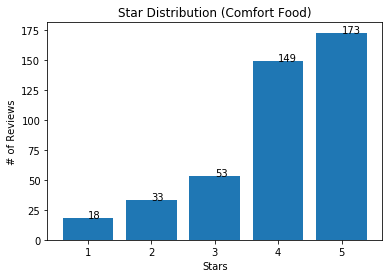

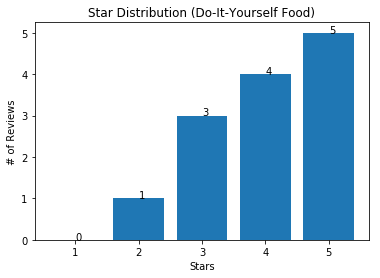

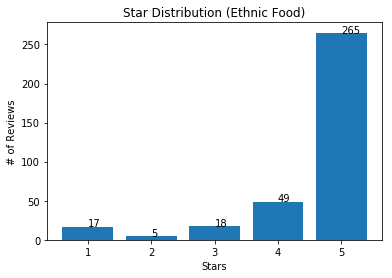

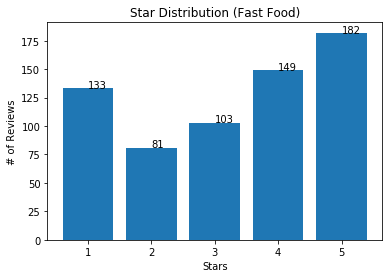

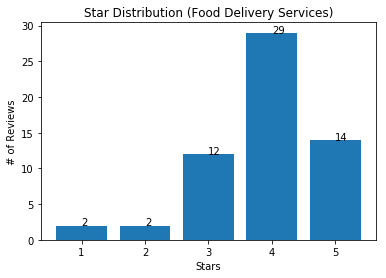

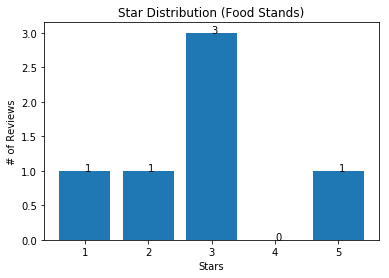

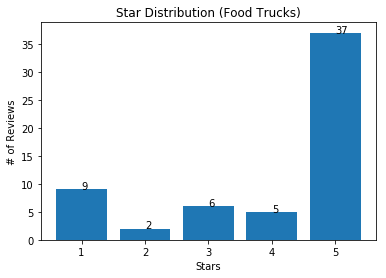

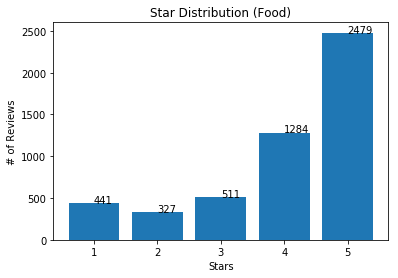

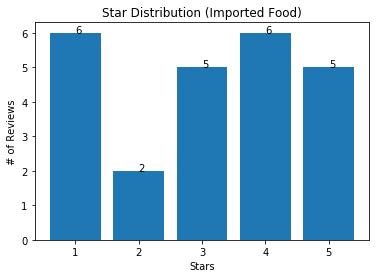

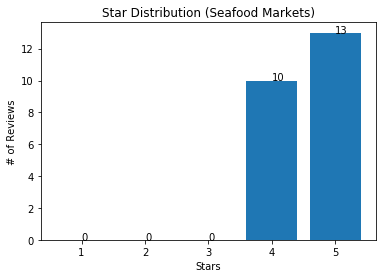

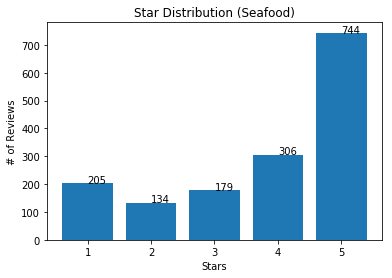

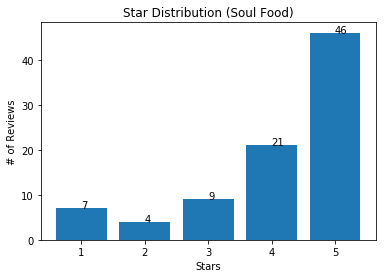

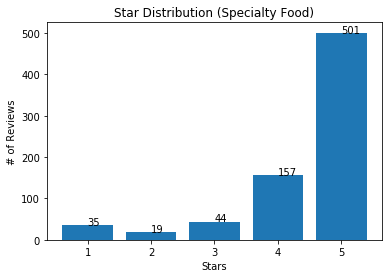

In [31]:
in_file = "categories_with_stars.csv"

display_type = "DISP_ALL"

print "Do you want to:\n\n"
print "a) Display all Categories"
print "b) Display Categories One by One, waiting for user confirmation via 'press any key'"
print "c) Display categories matching a search string"

option = raw_input()

if option.lower() == 'a':
    print 'Displaying all Categories ...\n'
elif option.lower() == 'b':
    print 'Displaying Categories One by One ...\n'
    display_type = "DISP_MANUAL"
elif option.lower() == 'c':
    query = raw_input("Search :\t")
    print '\nDisplaying results matching "' + query + '" ...\n' 
    display_type = "DISP_SEARCH"
else:
    print 'Option not recognized, plotting all categories...\n'

for line in open(in_file):
    line = line.strip().replace('"','').split(',')
    if len(line) != 6:
        continue
    category = line[0]
    if display_type == "DISP_SEARCH" and query.lower() not in category.lower():
        continue
    stars = map(int, [line[1], line[2], line[3], line[4], line[5]])
    plt.bar(range(len(stars)), stars, align='center')
    plt.title('Star Distribution (' + category + ')')
    plt.xlabel("Stars")
    plt.ylabel("# of Reviews")
    x = range(len(stars))
    y = stars
    for a,b in zip(x, y):
        plt.text(a, b, str(b))
    plt.xticks(range(len(stars)), [1,2,3,4,5])
    plt.show()
    if display_type == "DISP_MANUAL":
        ans = raw_input('Enter any key to plot the next category (q to exit) ...\n')
        if ans == 'q':
            break

    

And that's it! It is now possible to see the star distribution histogram for every category, and even to filter/narrow the results!

If you continue reading, you will see a bonus item, regarding the plotting of the images using a different library.

------------------------------------------------------------------------------

# BONUS

Since Lightning doesn't work properly for multiple graphs (histograms), the following snippet plots a category based on the user's input.

We start by importing the necessary libraries:
* sys: handling user input
* lightning: plotting the distribution histogram


In [32]:
import sys
from lightning import Lightning

Then, we proceed to open the previously generated CSV file and plot a category star distribution histogram based on the category that the user wants to see.

1) Accessories
2) Active Life
3) Acupuncture
4) Adult Education
5) Adult Entertainment
6) Adult
7) Advertising
8) African
9) Air Duct Cleaning
10) Airlines
11) Airport Shuttles
12) Airports
13) Amateur Sports Teams
14) American (New)
15) American (Traditional)
16) Amusement Parks
17) Animal Shelters
18) Antiques
19) Apartments
20) Appliances & Repair
21) Appliances
22) Arcades
23) Architects
24) Architectural Tours
25) Argentine
26) Armenian
27) Art Classes
28) Art Galleries
29) Art Schools
30) Art Supplies
31) Artificial Turf
32) Arts & Crafts
33) Arts & Entertainment
34) Asian Fusion
35) Auto Customization
36) Auto Detailing
37) Auto Glass Services
38) Auto Insurance
39) Auto Loan Providers
40) Auto Parts & Supplies
41) Auto Repair
42) Automotive
43) Baby Gear & Furniture
44) Bagels
45) Bakeries
46) Banks & Credit Unions
47) Bar Crawl
48) Barbeque
49) Barbers
50) Barre Classes
51) Bars
52) Basketball Courts
53) Battery Stores
54) Beauty & Spas
55) Beer Bar
56) Beer Gardens
57) Beer
5

Insert the number of the category to plot:	197



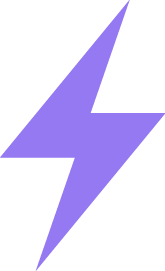

Connected to server at http://public.lightning-viz.org


<IPython.core.display.Javascript object>

Star Distribution (Food Delivery Services)


In [34]:
in_file = "categories_with_stars.csv"
categories = {}
for index, line in enumerate(open(in_file)):
    line = line.strip().replace('"','').split(',')
    if len(line) != 6:
        continue
    category = line[0]
    stars = map(int, [line[1], line[2], line[3], line[4], line[5]])
    converted_stars = []
    for idx,star in enumerate(stars):
        for i in range(star):
            converted_stars.append(idx+1)
    categories[index+1] = [category] + converted_stars
    print str(index+1)+') ' + category

selected_category = int(raw_input('Insert the number of the category to plot:\t'))
category_info = categories[selected_category]
category = category_info.pop(0)
stars = category_info

lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')
print 'Star Distribution (' + category + ')'
lgn.histogram(stars, 5, zoom=False)






And there it is!

We can now see the star distribution histograms for each category independently, using the Lightning Library.

Hope it was useful to you!

_

Juan Pablo Arévalo

Universidad de los Andes, Chile

jparevalo@miuandes.cl